# GRACE data preparation

Clipping the data around India from April 2002 to December 2016

In [1]:
#!pip install geopandas rioxarray xarray numpy

import geopandas as gpd
import rioxarray
import xarray as xr
import numpy as np
import pandas as pd

#### 1. Read data

In [2]:
ds = xr.open_mfdataset('./data/GRACE/*.nc')

In [3]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:        (lon: 720, lat: 360, time: 230, bounds: 2)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2kB 2002-04-17T12:00:00 ... 2024-02-...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 477MB dask.array<chunksize=(46, 72, 144), meta=np.ndarray>
    uncertainty    (time, lat, lon) float64 477MB dask.array<chunksize=(46, 72, 144), meta=np.ndarray>
    lat_bounds     (lat, bounds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    lon_bounds     (lon, bounds) float64 12kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    time_bounds    (time, bounds) datetime64[ns] 4kB dask.array<chunksize=(230, 2), meta=np.ndarray>
    land_mask      (lat, lon) float64 2MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    scale_factor   (lat, lon) float64 2MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    mascon_ID      (lat, lon) float64 2MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    GAD            (time, lat, lon) float64 477MB dask.array<chunksize=(46, 72, 144), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2024-04-25T02:04:21Z

#### 2. Select relevant months

In [4]:
sdate = '2002-04-01'
edate = '2016-12-31'
ds = ds.sel(time = slice(sdate, edate))

#### 3. Clip spatial extent around India

In [5]:
shape = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [ 60.0, 47.75 ],
            [ 100.0, 47.75 ],
            [ 100.0, 7.75 ],
            [ 60.0, 7.75 ],
            [ 60.0, 47.75 ]
        ]]
    }
]

global_twsa = ds['lwe_thickness']

# clipping
global_twsa.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
global_twsa.rio.write_crs('epsg:4326', inplace=True)
twsa = global_twsa.rio.clip(shape, global_twsa.rio.crs)

# converting from cm to mm
twsa *= 10

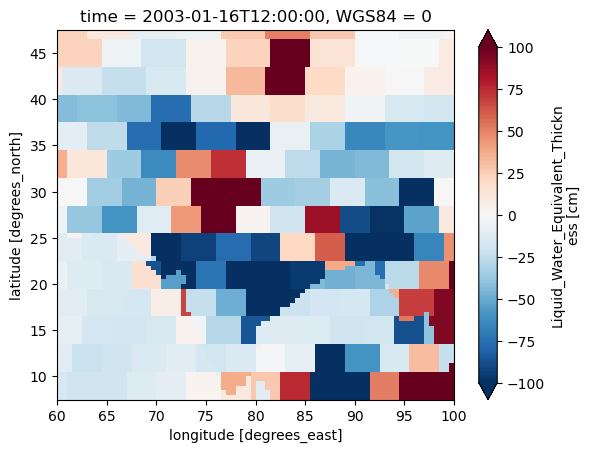

In [6]:
twsa[7,:,:].plot(cmap='RdBu_r', vmin=-100, vmax=100)

#### 4. Apply scaling factor

In [7]:
scale_factor = ds['scale_factor']
scale_factor.rio.write_crs('epsg:4326', inplace=True)

scaled_twsa = twsa * scale_factor

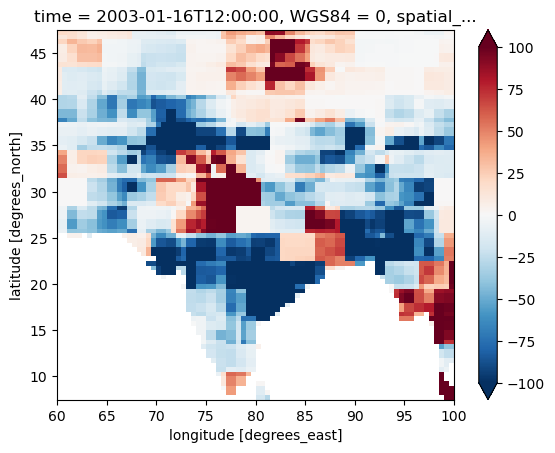

In [8]:
scaled_twsa[7,:,:].plot(cmap='RdBu_r', vmin=-100, vmax=100)

#### 5. Linear interpolation for the missing months

In [9]:
# shift the reported value from 01.01.2012 to 01.12.2011 and from 27.04.2015 to 01.05.2015 - manual fix for dupliate values reported for 01.2012 and 04.2015
scaled_twsa['time'].values[111] = pd.Timestamp(scaled_twsa['time'].values[111]) - pd.DateOffset(months=1)
scaled_twsa['time'].values[144] = pd.Timestamp(scaled_twsa['time'].values[144]) + pd.DateOffset(months=1)

resampled_twsa = scaled_twsa.resample(time='MS').asfreq()

filled_twsa = resampled_twsa.chunk(time=-1).interpolate_na(dim='time', method='linear')

#### 6. Use the 15th day of each month as time

In [10]:
filled_twsa['time'] = ('time', [pd.Timestamp(date).replace(day=15) for date in filled_twsa['time'].values])

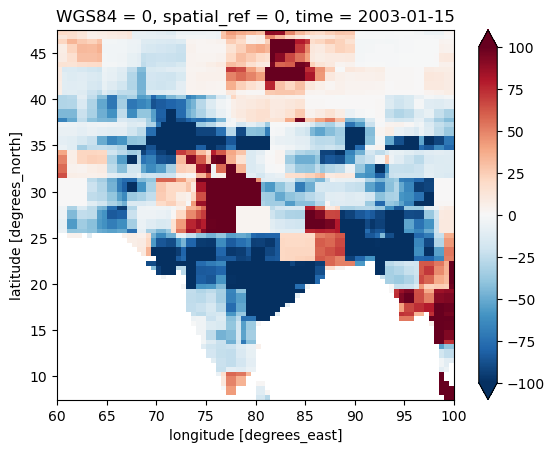

In [11]:
filled_twsa[9,:,:].plot(cmap='RdBu_r', vmin=-100, vmax=100)

#### 7. Save

In [12]:
filled_twsa.to_dataset(name='twsa_grace').to_netcdf('./data/GRACE/TWSA_M_2002_2016_India_05.nc4') # P